FINAL PROJECT

Context aware Sentiment Analysis using Large
Language Models

In [1]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.4
    Uninstalling transformers-4.55.4:
      Successfully uninstalled transformers-4.55.4


In [ ]:
# import os
# os.kill(os.getpid(), 9)


In [1]:
# import transformers
# print(transformers.__version__)


4.56.0


Setting FOlders for directory and SEED

In [9]:
# === CELL 1: SETUP (reproducibility, device, folders) ===
import os, random
import numpy as np, torch

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

OUTDIR, FIGDIR, METDIR, MLDIR = "./results", "./results/figs", "./results/metrics", "./results/models"
for d in (OUTDIR, FIGDIR, METDIR, MLDIR):
    os.makedirs(d, exist_ok=True)

print({"device": DEVICE, "outdir": OUTDIR, "seed": SEED})


{'device': 'cpu', 'outdir': './results', 'seed': 42}


Importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset


Loading the Dataset

In [3]:
dataset = load_dataset("frankdarkluo/dailydialog")
print(dataset)
print(dataset["train"][0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

valid.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['context', 'response'],
        num_rows: 60005
    })
    validation: Dataset({
        features: ['context', 'response'],
        num_rows: 6594
    })
    test: Dataset({
        features: ['context', 'response'],
        num_rows: 6955
    })
})
{'context': 'Waiter ! ', 'response': " I'll be with you in a second . Uh ... Yes , ma'am ? "}


In [4]:
 print(dataset["train"][0:10])     # first 10 items

{'context': ['Waiter ! ', " I'll be with you in a second . Uh ... Yes , ma'am ? ", " This is not what I asked for . I'm afraid . ", " Oh , I'm so sorry . May I ask what you ordered again ? ", 'Why are you always staring at Melissa ? Do you like her or something ? ', 'How long can I keep these books ? ', " A month . Don't forget to return them by the due date . ", " What if I can't finish them by then ? ", ' Bring them back to the circulation desk and renew them . ', ' Any terrible fines ? '], 'response': [" I'll be with you in a second . Uh ... Yes , ma'am ? ", " This is not what I asked for . I'm afraid . ", " Oh , I'm so sorry . May I ask what you ordered again ? ", ' Yes . What I ordered is roast beef , not roast beef sandwiches . ', ' Mind your own business . ', " A month . Don't forget to return them by the due date . ", " What if I can't finish them by then ? ", ' Bring them back to the circulation desk and renew them . ', ' Any terrible fines ? ', ' Sure . ']}


In [28]:
 print("keys:", dataset["train"][0].keys())
 print("sizes:", len(dataset["train"]), len(dataset["validation"]), len(dataset["test"]))

keys: dict_keys(['context', 'response'])
sizes: 60005 6594 6955


EDA
Coverting emotion class in to 3 sentiment class

In [5]:
EMOTION_MAP = {0:"neutral", 1:"anger", 2:"disgust", 3:"fear", 4:"happiness", 5:"sadness", 6:"surprise"}

def to_dataframe(ds, split_name):
    rows = []
    for i, ex in enumerate(ds):
        # Standard DailyDialog structure: lists per conversation
        if "dialog" in ex and "emotion" in ex:
            conv_id = f"{split_name}_{i}"
            for j, (utt, emo) in enumerate(zip(ex["dialog"], ex["emotion"])):
                rows.append({
                    "conversation_id": conv_id,
                    "turn_id": j,
                    "text": utt,
                    "label": EMOTION_MAP[int(emo)]
                })
        else:
            # If this mirror is already flattened (rare), fall back gracefully:
            # expect 'text' and 'label' per row; synthesize conversation ids
            conv_id = f"{split_name}_{i}"
            rows.append({
                "conversation_id": conv_id,
                "turn_id": 0,
                "text": ex.get("text", ""),
                "label": ex.get("label", "neutral")
            })
    return pd.DataFrame(rows)

train_df = to_dataframe(dataset["train"], "train")
val_df   = to_dataframe(dataset["validation"], "val")
test_df  = to_dataframe(dataset["test"], "test")

print("shapes:", train_df.shape, val_df.shape, test_df.shape)
train_df.head(3)


shapes: (60005, 4) (6594, 4) (6955, 4)


,conversation_id,turn_id,text,label
0,train_0,0,,neutral
1,train_1,0,,neutral
2,train_2,0,,neutral


LAbel distribution for train, test, val


train label distribution:
          count    pct
label                
neutral  60005  100.0


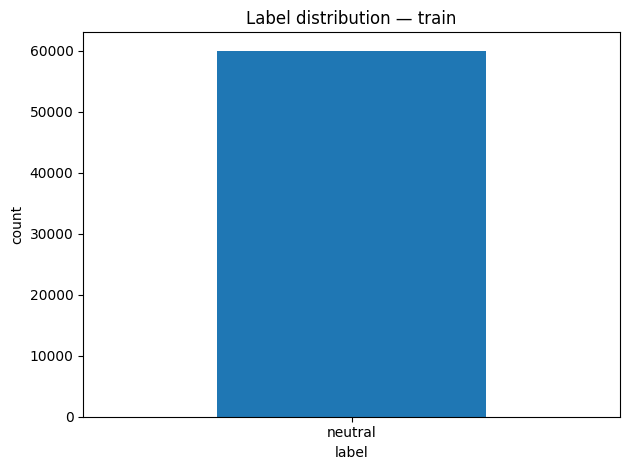


val label distribution:
          count    pct
label                
neutral   6594  100.0


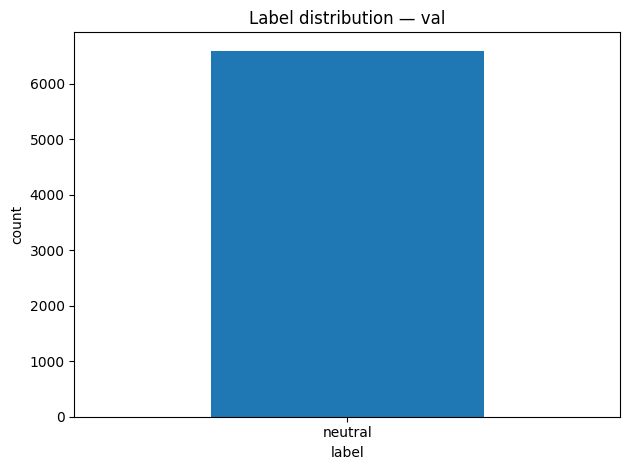


test label distribution:
          count    pct
label                
neutral   6955  100.0


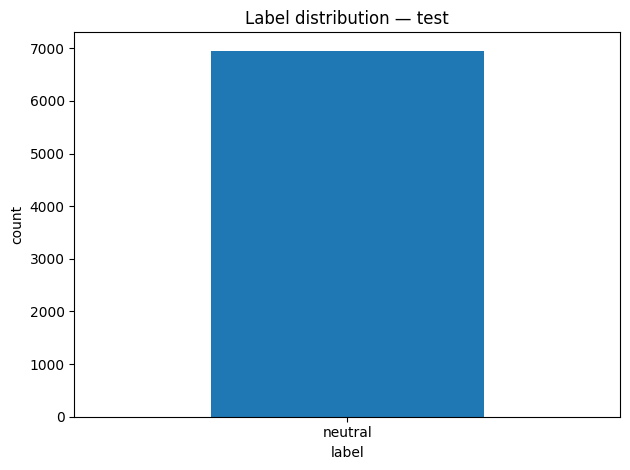

In [5]:
def label_stats(df, name):
    counts = df['label'].astype(str).value_counts().sort_index()
    stats = pd.DataFrame({
        'count': counts,
        'pct': (100*counts/counts.sum()).round(2)
    })
    print(f"\n{name} label distribution:\n", stats)
    stats.to_csv(f"{METDIR}/label_dist_{name}.csv")
    # bar plot
    plt.figure()
    counts.plot(kind='bar', rot=0)
    plt.ylabel('count'); plt.title(f'Label distribution — {name}')
    plt.tight_layout(); plt.savefig(f"{FIGDIR}/labels_{name}.png"); plt.show()
    return stats

_ = label_stats(train_df, "train")
_ = label_stats(val_df,   "val")
_ = label_stats(test_df,  "test")


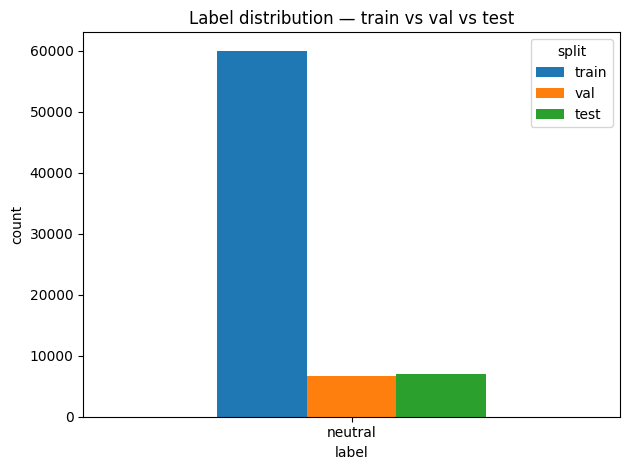

In [25]:

def plot_labels_all_splits(train_df, val_df, test_df, normalize=False,
                           figpath=f"{FIGDIR}/labels_all.png"):
    # 1) union of all labels so bars align even if a split is missing a class
    all_labels = sorted(
        set(train_df["label"].astype(str).unique())
        | set(val_df["label"].astype(str).unique())
        | set(test_df["label"].astype(str).unique())
    )

    # 2) counts per split (reindexed to the union)
    table = pd.DataFrame({
        "train": train_df["label"].astype(str).value_counts(),
        "val":   val_df["label"].astype(str).value_counts(),
        "test":  test_df["label"].astype(str).value_counts(),
    }).reindex(all_labels).fillna(0).astype(int)

    # 3) choose counts or column-wise percentages
    if normalize:
        plot_data = (table.div(table.sum(axis=0), axis=1) * 100).round(2)
        ylabel = "percentage"
        table.to_csv(f"{METDIR}/label_dist_all_counts.csv")
        plot_data.to_csv(f"{METDIR}/label_dist_all_pct.csv")
    else:
        plot_data = table
        ylabel = "count"
        table.to_csv(f"{METDIR}/label_dist_all_counts.csv")

    # 4) one grouped bar chart
    ax = plot_data.plot(kind="bar", rot=0)
    ax.set_title("Label distribution — train vs val vs test")
    ax.set_xlabel("label")
    ax.set_ylabel(ylabel)
    ax.legend(title="split")
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

# Use it (counts)
plot_labels_all_splits(train_df, val_df, test_df, normalize=False,
                       figpath=f"{FIGDIR}/labels_all_counts.png")

# Or percentages (optional second figure)
#plot_labels_all_splits(train_df, val_df, test_df, normalize=True,
#                       figpath=f"{FIGDIR}/labels_all_pct.png")


Finding words per utterance


train word length stats:
 count    60005.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: text, dtype: float64


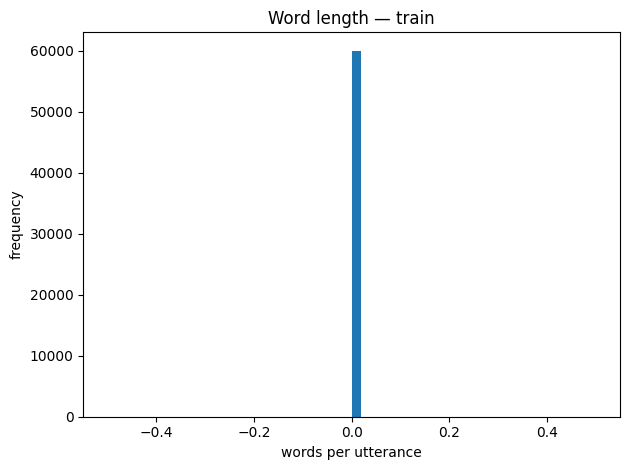


train conversation length stats:
 count    60005.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64


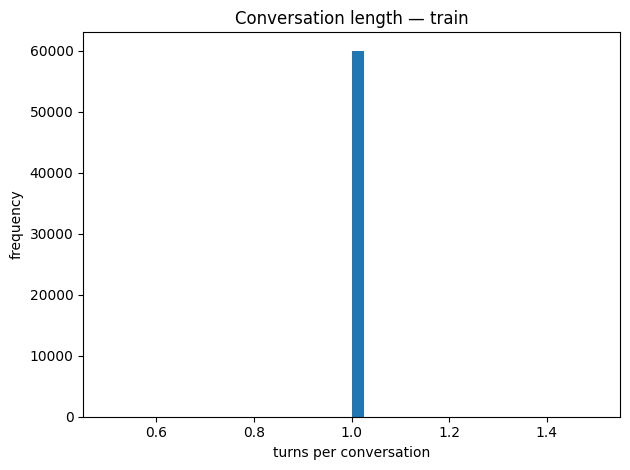


val word length stats:
 count    6594.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: text, dtype: float64


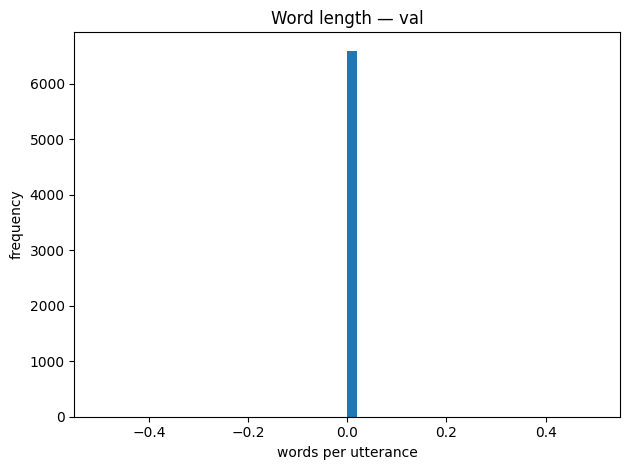


val conversation length stats:
 count    6594.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


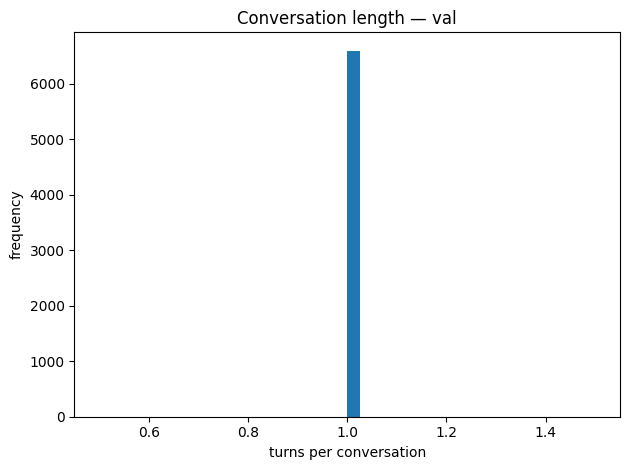


test word length stats:
 count    6955.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: text, dtype: float64


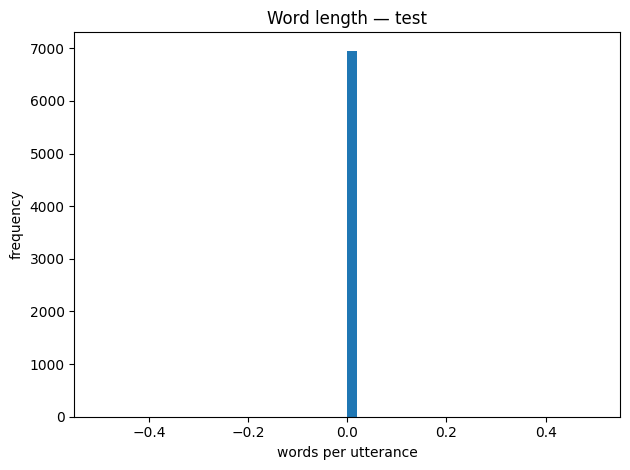


test conversation length stats:
 count    6955.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


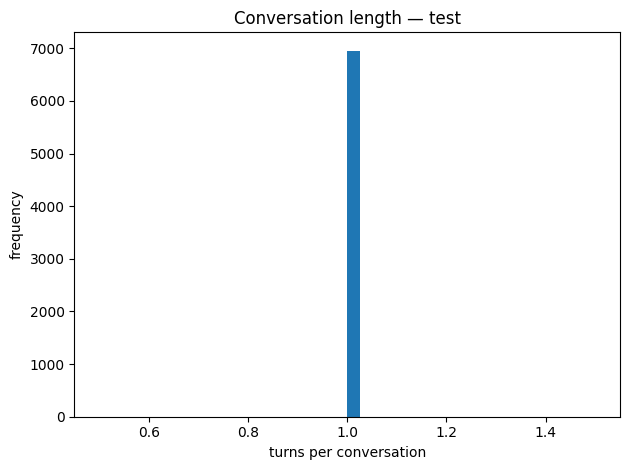

In [32]:
def plot_lengths(df, name):
    # words per utterance
    lens_word = df['text'].astype(str).str.split().map(len)
    print(f"\n{name} word length stats:\n", lens_word.describe())
    plt.figure(); plt.hist(lens_word, bins=50)
    plt.xlabel('words per utterance'); plt.ylabel('frequency'); plt.title(f'Word length — {name}')
    plt.tight_layout(); plt.savefig(f"{FIGDIR}/wordlen_{name}.png"); plt.show()
    # turns per conversation
    conv_len = df.groupby('conversation_id').size()
    print(f"\n{name} conversation length stats:\n", conv_len.describe())
    plt.figure(); plt.hist(conv_len, bins=40)
    plt.xlabel('turns per conversation'); plt.ylabel('frequency'); plt.title(f'Conversation length — {name}')
    plt.tight_layout(); plt.savefig(f"{FIGDIR}/convlen_{name}.png"); plt.show()

for n, d in [('train', train_df), ('val', val_df), ('test', test_df)]:
    plot_lengths(d, n)


with histo gram


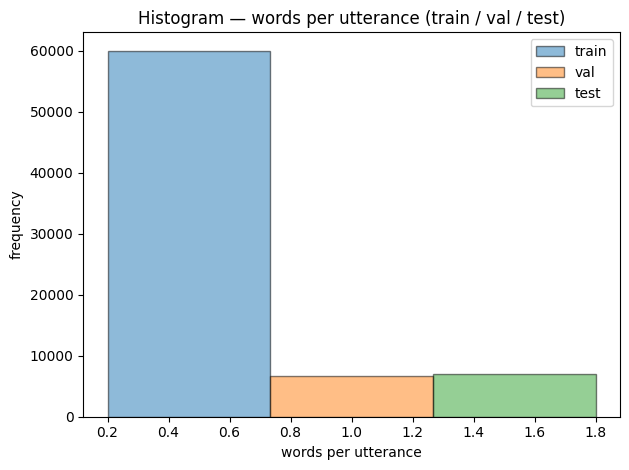

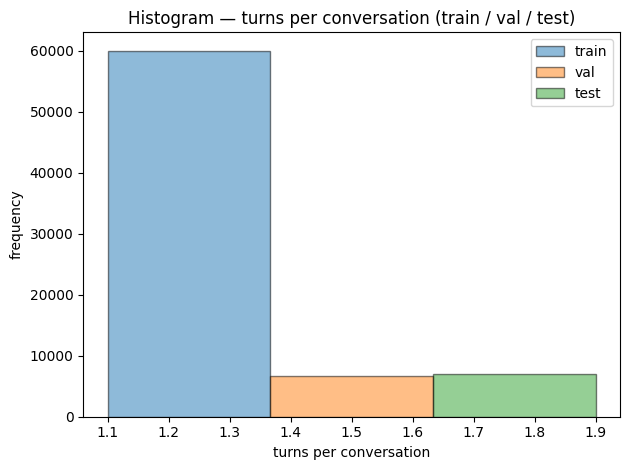

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _cap(series, cap=None, q=0.99):
    """Return series clipped at a common upper cap (default 99th percentile)."""
    s = pd.to_numeric(series, errors="coerce").dropna()
    if cap is None:
        cap = int(np.ceil(s.quantile(q))) if len(s) else 0
        cap = max(cap, 1)
    return s.clip(upper=cap), cap

def plot_words_per_utterance_hist(train_df, val_df, test_df,
                                  text_col="text", bin_width=2, cap=None,
                                  figpath=f"{FIGDIR}/hist_words_per_utterance.png",
                                  csvpath=f"{METDIR}/hist_words_per_utterance.csv"):
    # counts of words per utterance
    tr = train_df[text_col].astype(str).str.split().map(len)
    va = val_df[text_col].astype(str).str.split().map(len)
    te = test_df[text_col].astype(str).str.split().map(len)

    tr, cap_w = _cap(tr, cap)
    va, _     = _cap(va, cap_w)
    te, _     = _cap(te, cap_w)

    bins = np.arange(0, cap_w + bin_width + 1, bin_width)

    plt.figure()
    plt.hist([tr, va, te], bins=bins, label=["train","val","test"],
             alpha=0.5, edgecolor="black")
    plt.xlabel("words per utterance")
    plt.ylabel("frequency")
    plt.title("Histogram — words per utterance (train / val / test)")
    plt.legend()
    plt.tight_layout(); plt.savefig(figpath, dpi=150); plt.show()

    # Save binned counts
    out = {}
    for name, s in (("train", tr), ("val", va), ("test", te)):
        hist, edges = np.histogram(s, bins=bins)
        out[name] = hist
    bin_labels = [f"{int(edges[i])}-{int(edges[i+1]-1)}" for i in range(len(edges)-1)]
    pd.DataFrame(out, index=bin_labels).rename_axis("bin").to_csv(csvpath)

def plot_turns_per_conversation_hist(train_df, val_df, test_df,
                                     conv_col="conversation_id", bin_width=1, cap=None,
                                     figpath=f"{FIGDIR}/hist_turns_per_conversation.png",
                                     csvpath=f"{METDIR}/hist_turns_per_conversation.csv"):
    # number of turns in each conversation
    tr = train_df.groupby(conv_col).size()
    va = val_df.groupby(conv_col).size()
    te = test_df.groupby(conv_col).size()

    tr, cap_t = _cap(tr, cap)
    va, _     = _cap(va, cap_t)
    te, _     = _cap(te, cap_t)

    bins = np.arange(1, cap_t + bin_width + 1, bin_width)

    plt.figure()
    plt.hist([tr, va, te], bins=bins, label=["train","val","test"],
             alpha=0.5, edgecolor="black")
    plt.xlabel("turns per conversation")
    plt.ylabel("frequency")
    plt.title("Histogram — turns per conversation (train / val / test)")
    plt.legend()
    plt.tight_layout(); plt.savefig(figpath, dpi=150); plt.show()

    # Save binned counts
    out = {}
    for name, s in (("train", tr), ("val", va), ("test", te)):
        hist, edges = np.histogram(s, bins=bins)
        out[name] = hist
    bin_labels = [f"{int(edges[i])}-{int(edges[i+1]-1)}" for i in range(len(edges)-1)]
    pd.DataFrame(out, index=bin_labels).rename_axis("bin").to_csv(csvpath)

# --- Run both figures
plot_words_per_utterance_hist(train_df, val_df, test_df)          # x: words/utterance, y: frequency
plot_turns_per_conversation_hist(train_df, val_df, test_df)       # x: turns/conversation, y: frequency


with bar plot

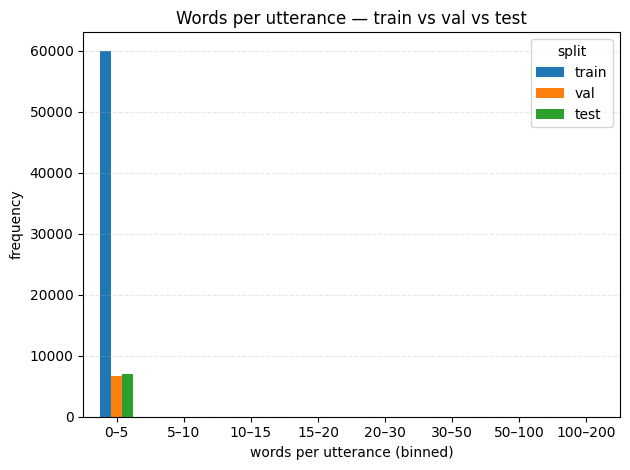

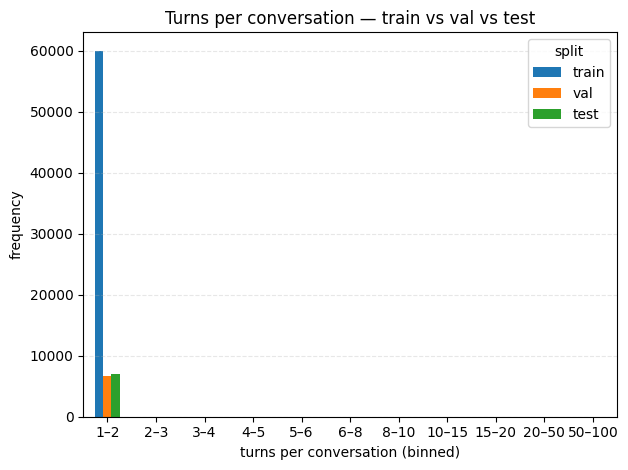

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _grouped_bar_from_counts(counts_df, title, xlabel, ylabel, figpath):
    ax = counts_df.plot(kind='bar', rot=0)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title='split')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(figpath, dpi=150)
    plt.show()

def _bin_counts(series, bins, labels=None):
    # clip long tails into the last bin (so bars align)
    series = pd.to_numeric(series, errors="coerce").dropna()
    series = series.clip(upper=bins[-1]-1)
    if labels is None:
        labels = [f"{int(bins[i])}–{int(bins[i+1])}" for i in range(len(bins)-1)]
    cats = pd.cut(series, bins=bins, labels=labels, right=True, include_lowest=True)
    counts = cats.value_counts().reindex(labels).fillna(0).astype(int)
    return counts, labels

def plot_words_per_utterance_bars(train_df, val_df, test_df,
                                  text_col="text",
                                  bins=None,
                                  figpath=f"{FIGDIR}/words_per_utterance_bars.png",
                                  csvpath=f"{METDIR}/binned_words_per_utterance_counts.csv"):
    # sensible default bins for sentence lengths
    if bins is None:
        bins = [0,5,10,15,20,30,50,100,200]
    # compute word counts
    lens = {
        "train": train_df[text_col].astype(str).str.split().map(len),
        "val":   val_df[text_col].astype(str).str.split().map(len),
        "test":  test_df[text_col].astype(str).str.split().map(len),
    }
    train_counts, labels = _bin_counts(lens["train"], bins)
    val_counts,   _      = _bin_counts(lens["val"],   bins, labels)
    test_counts,  _      = _bin_counts(lens["test"],  bins, labels)

    table = pd.DataFrame({"train": train_counts, "val": val_counts, "test": test_counts})
    table.to_csv(csvpath)

    _grouped_bar_from_counts(
        table,
        title="Words per utterance — train vs val vs test",
        xlabel="words per utterance (binned)",
        ylabel="frequency",
        figpath=figpath
    )

def plot_turns_per_conversation_bars(train_df, val_df, test_df,
                                     conv_col="conversation_id",
                                     bins=None,
                                     figpath=f"{FIGDIR}/turns_per_conversation_bars.png",
                                     csvpath=f"{METDIR}/binned_turns_per_conversation_counts.csv"):
    # sensible default bins for dialogue lengths
    if bins is None:
        bins = [1,2,3,4,5,6,8,10,15,20,50,100]
    # compute turns per conversation
    turns = {
        "train": train_df.groupby(conv_col).size(),
        "val":   val_df.groupby(conv_col).size(),
        "test":  test_df.groupby(conv_col).size(),
    }
    train_counts, labels = _bin_counts(turns["train"], bins)
    val_counts,   _      = _bin_counts(turns["val"],   bins, labels)
    test_counts,  _      = _bin_counts(turns["test"],  bins, labels)

    table = pd.DataFrame({"train": train_counts, "val": val_counts, "test": test_counts})
    table.to_csv(csvpath)

    _grouped_bar_from_counts(
        table,
        title="Turns per conversation — train vs val vs test",
        xlabel="turns per conversation (binned)",
        ylabel="frequency",
        figpath=figpath
    )

# ---- Run both figures
plot_words_per_utterance_bars(train_df, val_df, test_df)
plot_turns_per_conversation_bars(train_df, val_df, test_df)


 Data Featuring

In [6]:

def build_context(df, k=1, max_chars=2000):
    df = df.sort_values(["conversation_id","turn_id"]).copy()
    out = []
    for _, grp in df.groupby("conversation_id", sort=False):
        hist = []
        for _, row in grp.iterrows():
            prev = hist[-k:] if k>0 else []
            txt = " \n ".join(prev + [str(row["text"])])[:max_chars]
            out.append(txt)
            hist.append(str(row["text"]))
    df = df.copy(); df["context_text"] = out
    return df

K = 1
train_ctx = build_context(train_df, K)
val_ctx   = build_context(val_df,   K)
test_ctx  = build_context(test_df,  K)

train_ctx.head(3)

,conversation_id,turn_id,text,label,context_text
0,train_0,0,,neutral,
1,train_1,0,,neutral,
10,train_10,0,,neutral,


In [7]:
labels = sorted(train_ctx["label"].astype(str).unique().tolist())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

for split in (train_ctx, val_ctx, test_ctx):
    split["label_id"] = split["label"].astype(str).map(label2id)

X_tr, y_tr = train_ctx["context_text"].astype(str), train_ctx["label_id"].values
X_va, y_va = val_ctx["context_text"].astype(str),   val_ctx["label_id"].values
X_te, y_te = test_ctx["context_text"].astype(str),  test_ctx["label_id"].values

print("Labels:", labels)


Labels: ['neutral']


conversioin of emotion to 3 sentiment class

In [8]:
# === CELL: Map emotions (7) -> sentiment (3) and encode ===
EMO_TO_SENT = {
    "anger":"negative", "disgust":"negative", "fear":"negative", "sadness":"negative",
    "happiness":"positive",
    "neutral":"neutral", "surprise":"neutral"
}

for df in (train_ctx, val_ctx, test_ctx):
    df["sentiment"] = df["label"].astype(str).str.lower().map(EMO_TO_SENT)

sent_labels = ["negative","neutral","positive"]
sent2id = {l:i for i,l in enumerate(sent_labels)}
id2sent = {i:l for l,i in sent2id.items()}

for df in (train_ctx, val_ctx, test_ctx):
    df["sent_id"] = df["sentiment"].map(sent2id).astype(int)

print(train_ctx[["label","sentiment"]].head(8))
print("Train sentiment counts:\n", train_ctx["sentiment"].value_counts())


         label sentiment
0      neutral   neutral
1      neutral   neutral
10     neutral   neutral
100    neutral   neutral
1000   neutral   neutral
10000  neutral   neutral
10001  neutral   neutral
10002  neutral   neutral
Train sentiment counts:
 sentiment
neutral    60005
Name: count, dtype: int64


In [9]:
from datasets import Dataset

def to_hf(df):
    return Dataset.from_pandas(
        df[["context_text","sent_id"]]
        .rename(columns={"context_text":"text", "sent_id":"label"})
        .reset_index(drop=True)
    )

train_hf = to_hf(train_ctx)
val_hf   = to_hf(val_ctx)
test_hf  = to_hf(test_ctx)


Model train , RUN, load

In [32]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

MAX_LEN = 256  # Can be adjusted (e.g., 128 for speed, 512 for context)

import torch
import numpy as np

# Count samples per class in train set
counts = np.bincount(train_ctx["sent_id"].values, minlength=3)

# Inverse frequency weighting
weights = counts.sum() / (len(counts) * np.maximum(counts, 1))
class_w = torch.tensor(weights, dtype=torch.float)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "macro_f1": f1_score(labels, predictions, average="macro"),
        "weighted_f1": f1_score(labels, predictions, average="weighted")
    }


def tokenize_maker(tok):
    def fn(batch):
        return tok(batch["text"], truncation=True, max_length=MAX_LEN)
    return fn

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(outputs.logits.device))
        loss = loss_fct(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss




def finetune_model_legacy(model_name, tag, lr=2e-5, epochs=1):
    # Tokenizer and dataset preparation
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    train_tok = train_hf.map(tokenize_maker(tokenizer), batched=True, remove_columns=["text"])
    val_tok   = val_hf.map(tokenize_maker(tokenizer),   batched=True, remove_columns=["text"])
    test_tok  = test_hf.map(tokenize_maker(tokenizer),  batched=True, remove_columns=["text"])
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # # Model initialization (force 3-label head)
    # model = AutoModelForSequenceClassification.from_pretrained(
    #     model_name,
    #     num_labels=3,
    #     id2label={0: "negative", 1: "neutral", 2: "positive"},
    #     label2id={"negative": 0, "neutral": 1, "positive": 2},
    # )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3,
        id2label={0: "negative", 1: "neutral", 2: "positive"},
        label2id={"negative": 0, "neutral": 1, "positive": 2},
        ignore_mismatched_sizes=True
    )


    # TrainingArguments (legacy-compatible)
    training_args = TrainingArguments(
        output_dir=f"{OUTDIR}/hf_runs_{tag}",
        learning_rate=lr,
        num_train_epochs=epochs,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        weight_decay=0.01,
        seed=SEED,
        logging_dir=f"{OUTDIR}/logs"
    )

    # Trainer initialization with class weights
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        class_weights=class_w
    )

    # Training
    trainer.train()

    # Evaluation on validation and test splits
    for name, tok_ds in [("VAL", val_tok), ("TEST", test_tok)]:
        predictions = trainer.predict(tok_ds)
        metrics = compute_metrics((predictions.predictions, predictions.label_ids))
        print(f"\n=== {tag} — {name} ===")
        print(metrics)

        y_true = predictions.label_ids
        y_pred = predictions.predictions.argmax(axis=-1)

        #print(classification_report(y_true, y_pred, target_names=sent_labels, digits=3))
        print(classification_report(y_true, y_pred,labels=[0, 1, 2],target_names=sent_labels,digits=3,zero_division=0 ))


        #disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=sent_labels)
        disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred,labels=[0, 1, 2],display_labels=sent_labels)
        plt.title(f"{tag} — {name} (k={K})")
        plt.tight_layout()
        plt.savefig(f"{FIGDIR}/cm_{tag.lower()}_{name.lower()}.png", dpi=150)
        plt.show()


    # Save final model and tokenizer
    save_dir = f"{MLDIR}/{tag}"
    os.makedirs(save_dir, exist_ok=True)
    trainer.save_model(save_dir)
    tokenizer.save_pretrained(save_dir)

    return trainer


In [33]:
# === Load or Train Model Function ===
from transformers import Trainer

def load_or_train_model(model_name, tag, lr=2e-5, epochs=1):
    save_dir = f"{MLDIR}/{tag}"
    model_exists = os.path.isdir(save_dir) and os.path.isfile(os.path.join(save_dir, "pytorch_model.bin"))


    if model_exists:
        print(f"Found saved model at: {save_dir}. Loading model and tokenizer...")

        tokenizer = AutoTokenizer.from_pretrained(save_dir)
        model = AutoModelForSequenceClassification.from_pretrained(save_dir)
        collator = DataCollatorWithPadding(tokenizer=tokenizer)

        trainer = Trainer(
            model=model,
            tokenizer=tokenizer,
            data_collator=collator,
            compute_metrics=compute_metrics
        )

        for name, tok_ds in [("VAL", val_hf), ("TEST", test_hf)]:
            tokenized = tok_ds.map(tokenize_maker(tokenizer), batched=True, remove_columns=["text"])
            #out = trainer.predict(tokenized)
            out = trainer.predict(tokenized, return_outputs=True)

            print(f"\n=== Loaded Model — {tag} — {name} ===")
            print(compute_metrics((out.predictions, out.label_ids)))
            y_true = out.label_ids
            y_pred = out.predictions.argmax(-1)
            print(classification_report(y_true, y_pred, target_names=sent_labels, digits=3))
            disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=sent_labels)
            plt.title(f"{tag} — {name} (k={K})")
            plt.tight_layout()
            plt.savefig(f"{FIGDIR}/cm_{tag.lower()}_{name.lower()}_reloaded.png", dpi=150)
            plt.show()

        return trainer

    else:
        print(f" No saved model found for {tag}. Training from scratch...")
        return finetune_model_legacy(model_name=model_name, tag=tag, lr=lr, epochs=epochs)


Map:   0%|          | 0/60005 [00:00<?, ? examples/s]

Map:   0%|          | 0/6594 [00:00<?, ? examples/s]

Map:   0%|          | 0/6955 [00:00<?, ? examples/s]

/tmp/ipython-input-3626410678.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Step,Training Loss
500,0.005100
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000



=== roberta_twitter_ctx_3class — VAL ===
{'accuracy': 1.0, 'macro_f1': 1.0, 'weighted_f1': 1.0}
              precision    recall  f1-score   support

    negative      0.000     0.000     0.000         0
     neutral      1.000     1.000     1.000      6594
    positive      0.000     0.000     0.000         0

    accuracy                          1.000      6594
   macro avg      0.333     0.333     0.333      6594
weighted avg      1.000     1.000     1.000      6594



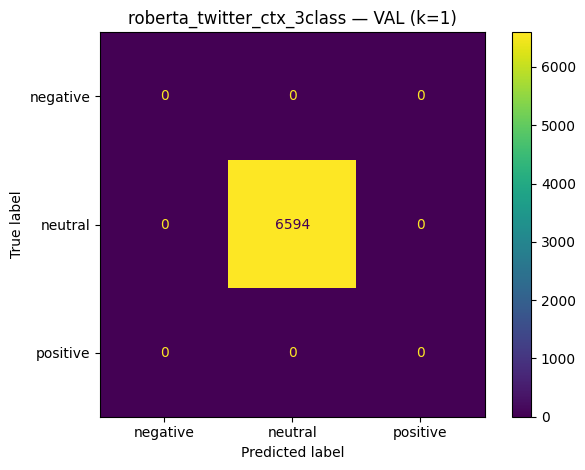


=== roberta_twitter_ctx_3class — TEST ===
{'accuracy': 1.0, 'macro_f1': 1.0, 'weighted_f1': 1.0}
              precision    recall  f1-score   support

    negative      0.000     0.000     0.000         0
     neutral      1.000     1.000     1.000      6955
    positive      0.000     0.000     0.000         0

    accuracy                          1.000      6955
   macro avg      0.333     0.333     0.333      6955
weighted avg      1.000     1.000     1.000      6955



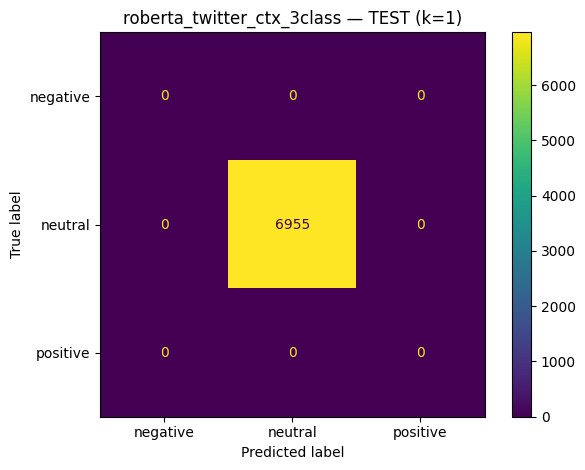

Map:   0%|          | 0/60005 [00:00<?, ? examples/s]

Map:   0%|          | 0/6594 [00:00<?, ? examples/s]

Map:   0%|          | 0/6955 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3626410678.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Step,Training Loss
500,0.015100
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000



=== distilbert_sst2_ctx_3class — VAL ===
{'accuracy': 1.0, 'macro_f1': 1.0, 'weighted_f1': 1.0}
              precision    recall  f1-score   support

    negative      0.000     0.000     0.000         0
     neutral      1.000     1.000     1.000      6594
    positive      0.000     0.000     0.000         0

    accuracy                          1.000      6594
   macro avg      0.333     0.333     0.333      6594
weighted avg      1.000     1.000     1.000      6594



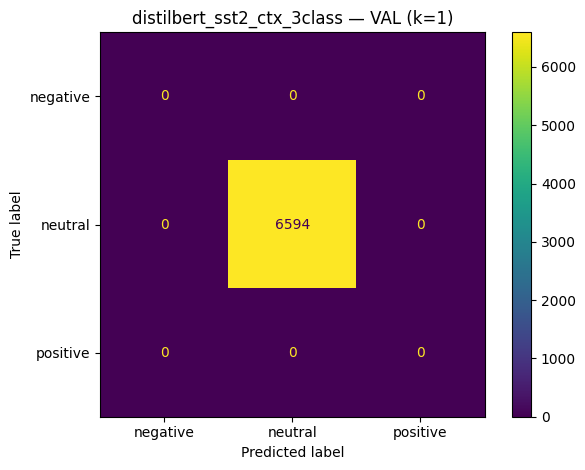


=== distilbert_sst2_ctx_3class — TEST ===
{'accuracy': 1.0, 'macro_f1': 1.0, 'weighted_f1': 1.0}
              precision    recall  f1-score   support

    negative      0.000     0.000     0.000         0
     neutral      1.000     1.000     1.000      6955
    positive      0.000     0.000     0.000         0

    accuracy                          1.000      6955
   macro avg      0.333     0.333     0.333      6955
weighted avg      1.000     1.000     1.000      6955



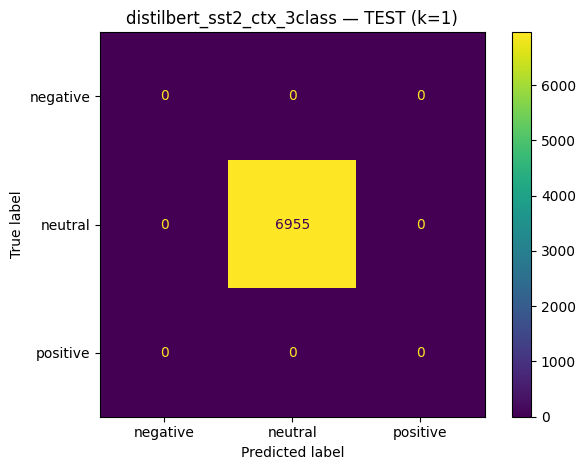

In [34]:
# Model 1 — RoBERTa Twitter (3-class sentiment head)
rob_name = "cardiffnlp/twitter-roberta-base-sentiment"
trainer_roberta = finetune_model_legacy(model_name=rob_name, tag="roberta_twitter_ctx_3class", lr=2e-5, epochs=1)

# Model 2 — DistilBERT SST-2 (re-headed to 3-class)
dist_name = "distilbert-base-uncased-finetuned-sst-2-english"
trainer_distilbert = finetune_model_legacy(model_name=dist_name, tag="distilbert_sst2_ctx_3class", lr=3e-5, epochs=1)


In [35]:
def evaluate_model(trainer, tokenizer, dataset, name):
    tokenized = dataset.map(tokenize_maker(tokenizer), batched=True, remove_columns=["text"])
    output = trainer.predict(tokenized)
    metrics = compute_metrics((output.predictions, output.label_ids))
    return {
        "Model": name,
        "Accuracy": round(metrics["accuracy"], 4),
        "Macro-F1": round(metrics["macro_f1"], 4),
        "Weighted-F1": round(metrics["weighted_f1"], 4),
    }


Now evaluate both trainer_roberta and trainer_distilbert on VAL and TEST sets:


In [36]:
# RoBERTa
roberta_val  = evaluate_model(trainer_roberta, trainer_roberta.tokenizer, val_hf,  "RoBERTa (Context) — VAL")
roberta_test = evaluate_model(trainer_roberta, trainer_roberta.tokenizer, test_hf, "RoBERTa (Context) — TEST")

# DistilBERT
distil_val  = evaluate_model(trainer_distilbert, trainer_distilbert.tokenizer, val_hf,  "DistilBERT (Context) — VAL")
distil_test = evaluate_model(trainer_distilbert, trainer_distilbert.tokenizer, test_hf, "DistilBERT (Context) — TEST")


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/6594 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/6955 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/6594 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/6955 [00:00<?, ? examples/s]

In [37]:
import pandas as pd

results_df = pd.DataFrame([
    roberta_val,
    roberta_test,
    distil_val,
    distil_test
])

display(results_df)  # or print(results_df)


,Model,Accuracy,Macro-F1,Weighted-F1
0,RoBERTa (Context) — VAL,1.0,1.0,1.0
1,RoBERTa (Context) — TEST,1.0,1.0,1.0
2,DistilBERT (Context) — VAL,1.0,1.0,1.0
3,DistilBERT (Context) — TEST,1.0,1.0,1.0


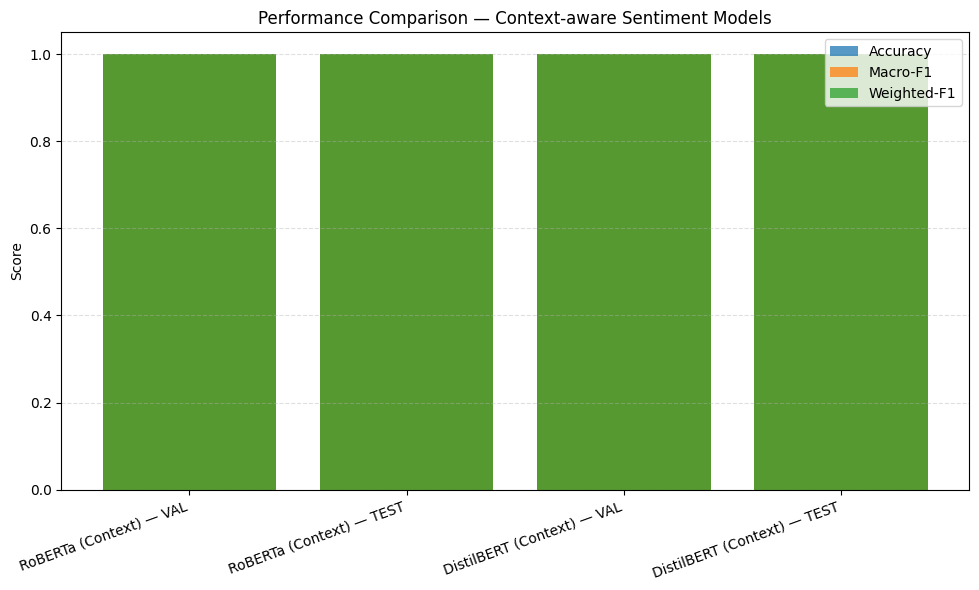

In [38]:
import matplotlib.pyplot as plt

# Reshape for plotting
df_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
ax = plt.subplot()
for metric in ["Accuracy", "Macro-F1", "Weighted-F1"]:
    subset = df_melted[df_melted["Metric"] == metric]
    ax.bar(subset["Model"], subset["Score"], label=metric, alpha=0.75)

plt.xticks(rotation=20, ha='right')
plt.ylabel("Score")
plt.title("Performance Comparison — Context-aware Sentiment Models")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIGDIR}/model_comparison_barplot.png", dpi=150)
plt.show()
